In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import f90_src
import scipy
from scipy.optimize import minimize

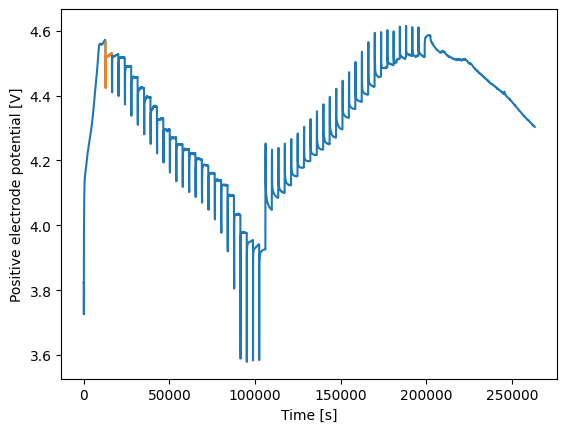

In [2]:
#Read in the experiental data 
df = pd.read_csv("data3.csv")
t = df['Time [s]']
t = t.to_numpy(t)
pot = df['Positive electrode potential [V]']
pot = pot.to_numpy(pot)
curr = df['Current [A]']
curr = curr.to_numpy(curr)
ind = df['Index']
ind = ind.to_numpy(ind)


#Separate the data in 2 sections and find the maxima 
sec1 = curr[:6770]
sec2 = curr[6769:]
potmin = []
timemin = []
indices = [] 

for i in range(1, len(sec1)-1):
    #if (curr[i] == 0) and ((curr[i] - curr[i-1]) < 0):
    if (curr[i] == 0) and ((curr[i+1] - curr[i]) > 0):
        potmin.append(pot[i-1])
        timemin.append(t[i-1])
        indices.append(ind[i-1])

for i in range(6769, 6769+len(sec2)-1):
    #if (curr[i] == 0) and ((curr[i+1] - curr[i]) > 0):
    if (curr[i] == 0) and ((curr[i] - curr[i-1]) < 0):
        potmin.append(pot[i+1])
        timemin.append(t[i+1])
        indices.append(ind[i+1])


#Clean up the irrelevant maxima
potmin = np.array(potmin)
timemin = np.array(timemin)
indices = np.array(indices)
indices_to_remove = [0, 1, 53, 54]
potmin = potmin[~np.isin(np.arange(potmin.size), indices_to_remove)]
timemin = timemin[~np.isin(np.arange(timemin.size), indices_to_remove)]
indices = indices[~np.isin(np.arange(indices.size), indices_to_remove)]

#Split the data into chunks 
pot_split = np.split(pot, indices)
t_split = np.split(t, indices)

#Plotting 
plt.plot(t, pot)
#uncomment to zoom in at a particular time section
#plt.xlim(100000,110000)

#Plots the maxima
#plt.plot(timemin, potmin, 'x')

#Plots the chunk 
plt.plot(t_split[1], pot_split[1])
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.show()

In [3]:
n = 20
D = 1.48 * 10**(-15)
R = 5.22 * 10**(-6)
volPer = 66.5
iapp = 0.001
F = 96485.3321
L = 75.6 * 10**(-6)
Rg = 8.31446261815324
T = 294.15
K = 3.42
maxCon = 51765.0000001
c0 = np.ones(n, order="F")
c0 = c0*1000
c0 = np.asfortranarray(c0)
#timeArr = t_split[1] 
#timeArr = np.asfortranarray(timeArr)
#maxcon=np.array([maxCon], dtype=float)
dt = 1
i = 1
totaltime = int(t_split[1][-1]-t_split[1][0])

In [4]:
totaltime

3690

In [5]:
def voltages_data(D, totaltime):
    volt = np.array((totaltime), order="F")
    volt = f90_src.datafitpde.crank_nicholson(n=n, totaltime=totaltime, d=D, r=R, volper=volPer,
                                              iapp=iapp, f=F, l=L, rg=Rg, t=T, k=K, maxcon=maxCon,
                                              c0=c0, dt=dt)
    return volt 
volt = voltages_data(D, totaltime)

 flux:    1.4348433946972988E-008


In [6]:
volt

array([4.66273898, 4.66273898, 4.66273898, ..., 4.66273898, 4.66273898,
       4.66273898])

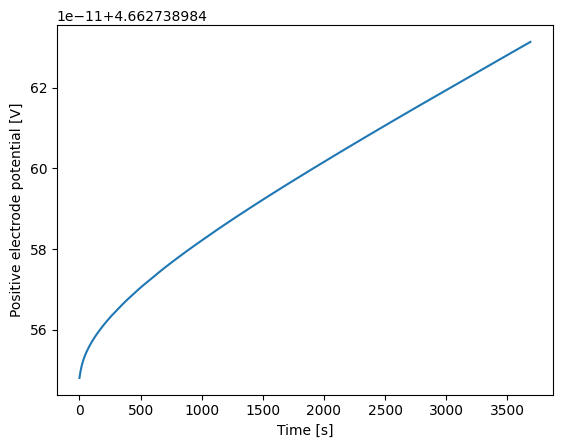

In [19]:
time_plot = np.zeros(totaltime)
for i in range(totaltime):
    time_plot[i]=i 
    
plt.plot(time_plot, volt)
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.show()

In [ ]:
def error(i):
    volt = voltages_data(D, totaltime)
    err = volt-pot_split[1]
    return err

In [ ]:
D_guess = np.linspace(1.48e-15)

optim = minimize(fun=error, D_guess,  )